In [1]:
import numpy as np
import torch
import pyepo

# random seed
np.random.seed(42)
torch.manual_seed(42)

Auto-Sklearn cannot be imported.


## Data Set and Optimization Solver

In [2]:
# generate data
num_node = 20 # node size
num_data = 100 # number of training data
num_feat = 10 # size of feature
deg = 4 # polynomial degree
e = 0.5 # noise width
feats, costs = pyepo.data.tsp.genData(num_data+1000, num_feat, num_node, deg, e, seed=42)

In [3]:
from model import tspDFJModel
# set solver
optmodel = tspDFJModel(num_node)
# test
optmodel.setObj(costs[0])
sol, obj = optmodel.solve()
print("Obj: {}".format(obj))
tour = optmodel.getTour(sol)
print(" -> ".join(map(str, tour)))

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-01
Obj: 58.7221
0 -> 10 -> 16 -> 5 -> 3 -> 17 -> 1 -> 4 -> 12 -> 14 -> 9 -> 11 -> 2 -> 7 -> 18 -> 13 -> 6 -> 19 -> 8 -> 15 -> 0


In [4]:
# split data
from sklearn.model_selection import train_test_split
x_train, x_test, c_train, c_test = train_test_split(feats, costs, test_size=1000, random_state=42)

In [5]:
# get training and test data set
dataset_train_cost = pyepo.data.dataset.optDataset(optmodel, x_train, costs=c_train)
dataset_test = pyepo.data.dataset.optDataset(optmodel, x_test, costs=c_test)

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 108.62it/s]


Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 84.91it/s]


In [6]:
from dataset import optDatasetConstrs
dataset_train = optDatasetConstrs(optmodel, x_train, costs=c_train) # with binding constr

Optimizing for optDataset...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 47.87it/s]


In [7]:
# get data loader
from torch.utils.data import DataLoader
from dataset import collate_fn
batch_size = 32
loader_train_cost = DataLoader(dataset_train_cost, batch_size=batch_size, shuffle=True)
loader_train = DataLoader(dataset_train, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)

## Prediction Model

In [8]:
import torch
from torch import nn

# build linear model
class LinearRegression(nn.Module):

    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(num_feat, num_node*(num_node-1)//2)

    def forward(self, x):
        out = self.linear(x)
        return out

## Plot 

In [9]:
from matplotlib import pyplot as plt
def plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step):
    # draw loss plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(loss_log, color="c", lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Loss", fontsize=36)
    plt.title("Loss Curve on Training Set", fontsize=36)
    plt.show()
    # draw regret plot for test
    fig = plt.figure(figsize=(16, 8))
    plt.plot([i * log_step for i in range(len(regret_log_trn))], regret_log_trn,
             color="royalblue", ls="--", alpha=0.7, lw=5, label="Train")
    plt.plot([i * log_step for i in range(len(regret_log_val))], regret_log_val,
             color="lightcoral", ls=":", alpha=0.7, lw=5, label="Val")
    plt.xlim(-10, num_epochs+10)
    plt.ylim(0, 0.8)
    plt.xticks(range(0, num_epochs+1, 50), fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Epoch", fontsize=36)
    plt.ylabel("Regret", fontsize=36)
    plt.legend(fontsize=32)
    plt.title("Regret Curve on Training and Validation Set", fontsize=36)
    plt.show()

## Train

In [10]:
import time
from earlystop import earlyStopper

def train(reg, loss_func, lr, num_epochs, log_step):
    # set optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
    # set stopper
    stopper = earlyStopper(patience=3)
    # init log
    loss_log = []
    regret_log_trn = [pyepo.metric.regret(reg, optmodel, loader_train_cost)]
    regret_log_val = [pyepo.metric.regret(reg, optmodel, loader_test)]
    # running time
    elapsed = 0
    for epoch in range(num_epochs):
        tick = time.time()
        for data in loader_train:
            x, _, _, t_ctr = data
            # forward pass
            cp = reg(x)
            loss = loss_func(cp, t_ctr)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_log.append(loss.item())
        # record time
        tock = time.time()
        elapsed += tock - tick
        if (epoch+1) % log_step == 1:
            # regret
            regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
            regret_log_trn.append(regret_trn)
            regret_val = pyepo.metric.regret(reg, optmodel, loader_test)
            regret_log_val.append(regret_val)
            print("Epoch {:3}, Loss: {:8.4f}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
                  format(epoch, loss.item(), regret_trn*100, regret_val*100))
            # early stop
            if stopper.stop(regret_val):
                print("Early Stop!")
                break
    print("Elapsed Time: {:.2f} Sec".format(elapsed))
    return loss_log, regret_log_trn, regret_log_val

### 2-Stage 

In [11]:
# init model
reg = LinearRegression()

In [12]:
from torch import nn
# init loss
mse = nn.MSELoss()

In [13]:
lr = 5e-2
num_epochs = 400
log_step = 20
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
# set stopper
stopper = earlyStopper(patience=3)
# init log
loss_log = []
regret_log_trn = [pyepo.metric.regret(reg, optmodel, loader_train_cost)]
regret_log_val = [pyepo.metric.regret(reg, optmodel, loader_test)]
# running time
elapsed = 0
for epoch in range(num_epochs):
    tick = time.time()
    for data in loader_train:
        x, c, _, _ = data
        # forward pass
        cp = reg(x)
        loss = mse(cp, c)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_log.append(loss.item())
    # record time
    tock = time.time()
    elapsed += tock - tick
    if (epoch+1) % log_step == 1:
        # regret
        regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
        regret_log_trn.append(regret_trn)
        regret_val = pyepo.metric.regret(reg, optmodel, loader_test)
        regret_log_val.append(regret_val)
        print("Epoch {:3}, Loss: {:8.4f}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
              format(epoch, loss.item(), regret_trn*100, regret_val*100))
        # early stop
        if stopper.stop(regret_val):
            print("Early Stop!")
            break
print("Elapsed Time: {:.2f} Sec".format(elapsed))

Epoch   0, Loss:  47.4542, Train Regret: 102.8860%, Val Regret: 117.6926%
Epoch  20, Loss:  13.0517, Train Regret:  21.9561%, Val Regret:  24.1884%
Epoch  40, Loss:   4.3930, Train Regret:  17.3520%, Val Regret:  19.5088%
Epoch  60, Loss:  12.5451, Train Regret:  15.8411%, Val Regret:  17.3756%
Epoch  80, Loss:   8.8629, Train Regret:  13.8236%, Val Regret:  15.8050%
Epoch 100, Loss:   5.0492, Train Regret:  13.9112%, Val Regret:  15.7455%
Epoch 120, Loss:   8.0730, Train Regret:  13.6914%, Val Regret:  15.4032%
Epoch 140, Loss:   4.6407, Train Regret:  13.8727%, Val Regret:  15.3838%
Epoch 160, Loss:   7.8581, Train Regret:  13.7796%, Val Regret:  15.2799%
Epoch 180, Loss:   9.1762, Train Regret:  13.6279%, Val Regret:  15.1517%
Epoch 200, Loss:   8.1834, Train Regret:  13.6639%, Val Regret:  15.5565%
Epoch 220, Loss:   9.2033, Train Regret:  14.2760%, Val Regret:  15.4346%
Epoch 240, Loss:   7.0610, Train Regret:  13.8362%, Val Regret:  15.5776%
Early Stop!
Elapsed Time: 3.85 Sec


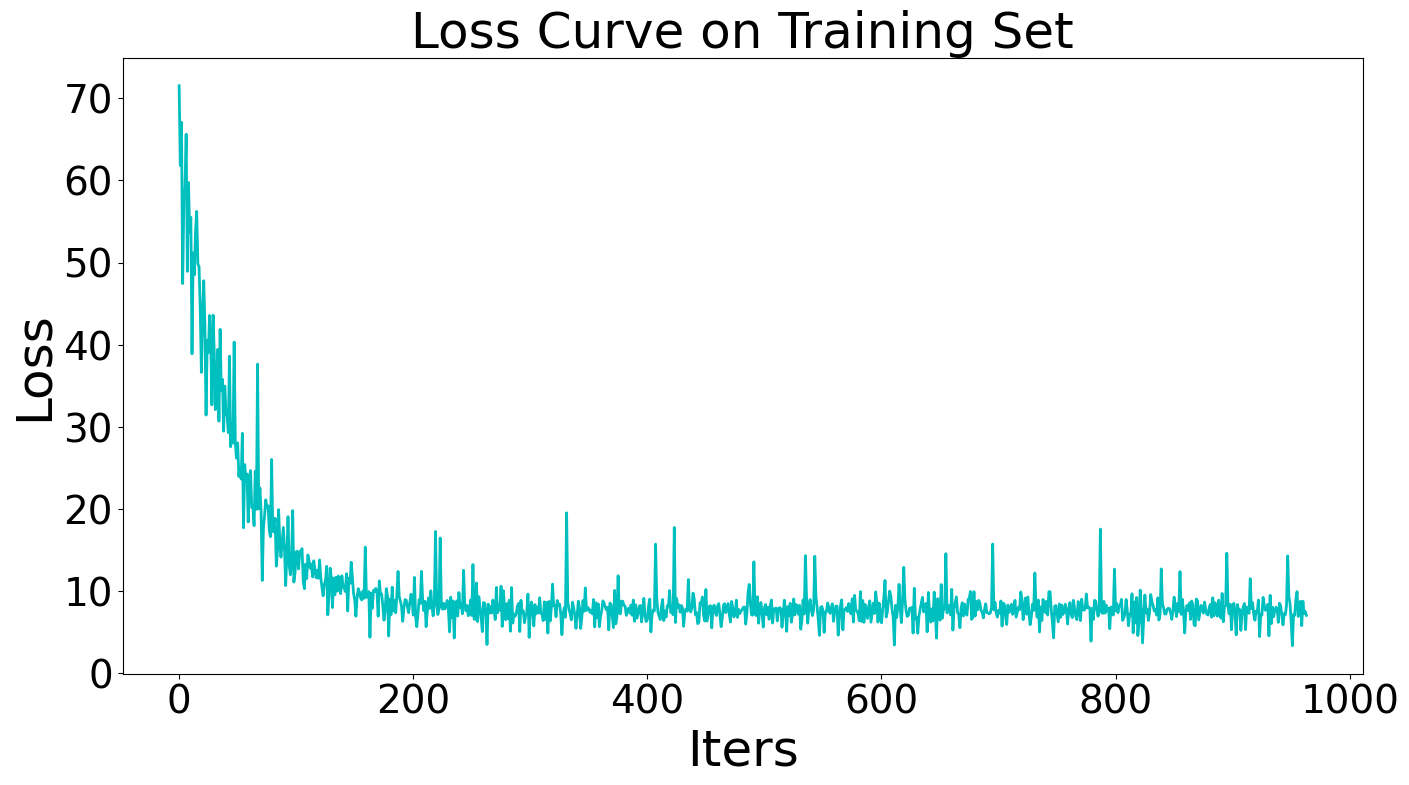

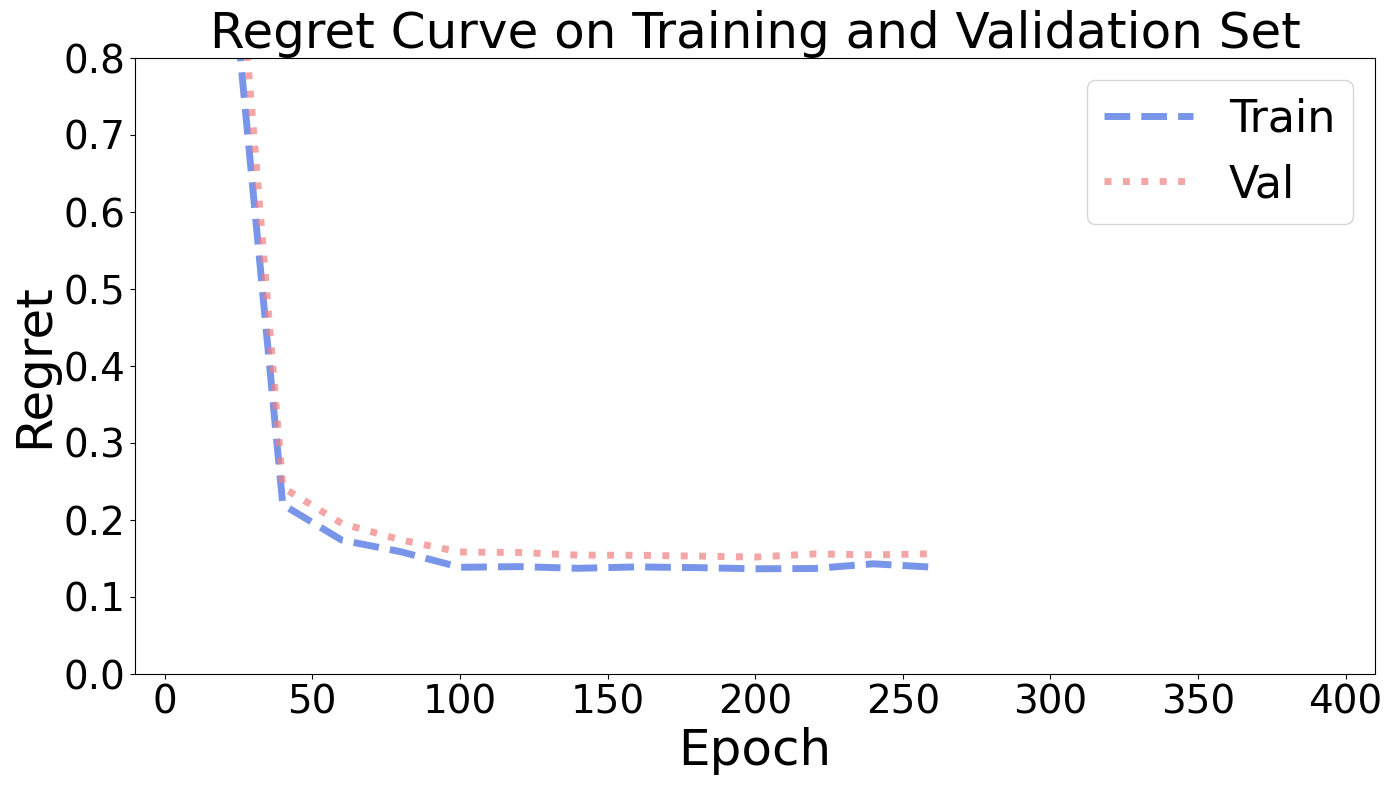

In [14]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Exact Method 

In [15]:
# init model
reg = LinearRegression()

In [16]:
from func import exactConeAlignedCosine
# init loss
ca_cos = exactConeAlignedCosine(optmodel)

In [17]:
lr = 5e-2
num_epochs = 400
log_step = 20
loss_log, regret_log_trn, regret_log_val = train(reg, ca_cos, lr, num_epochs, log_step)

Epoch   0, Loss:  -0.9418, Train Regret: 100.5212%, Val Regret: 112.1770%
Epoch  20, Loss:  -0.9999, Train Regret:  11.6444%, Val Regret:  28.4888%
Epoch  40, Loss:  -1.0000, Train Regret:   7.0536%, Val Regret:  27.4493%
Epoch  60, Loss:  -1.0000, Train Regret:   4.4869%, Val Regret:  27.3785%
Epoch  80, Loss:  -1.0000, Train Regret:   3.4556%, Val Regret:  27.3322%
Epoch 100, Loss:  -1.0000, Train Regret:   0.6088%, Val Regret:  27.3181%
Epoch 120, Loss:  -1.0000, Train Regret:   0.0000%, Val Regret:  27.3483%
Epoch 140, Loss:  -1.0000, Train Regret:   0.0000%, Val Regret:  27.3450%
Epoch 160, Loss:  -1.0000, Train Regret:   0.0000%, Val Regret:  27.4098%
Early Stop!
Elapsed Time: 351.36 Sec


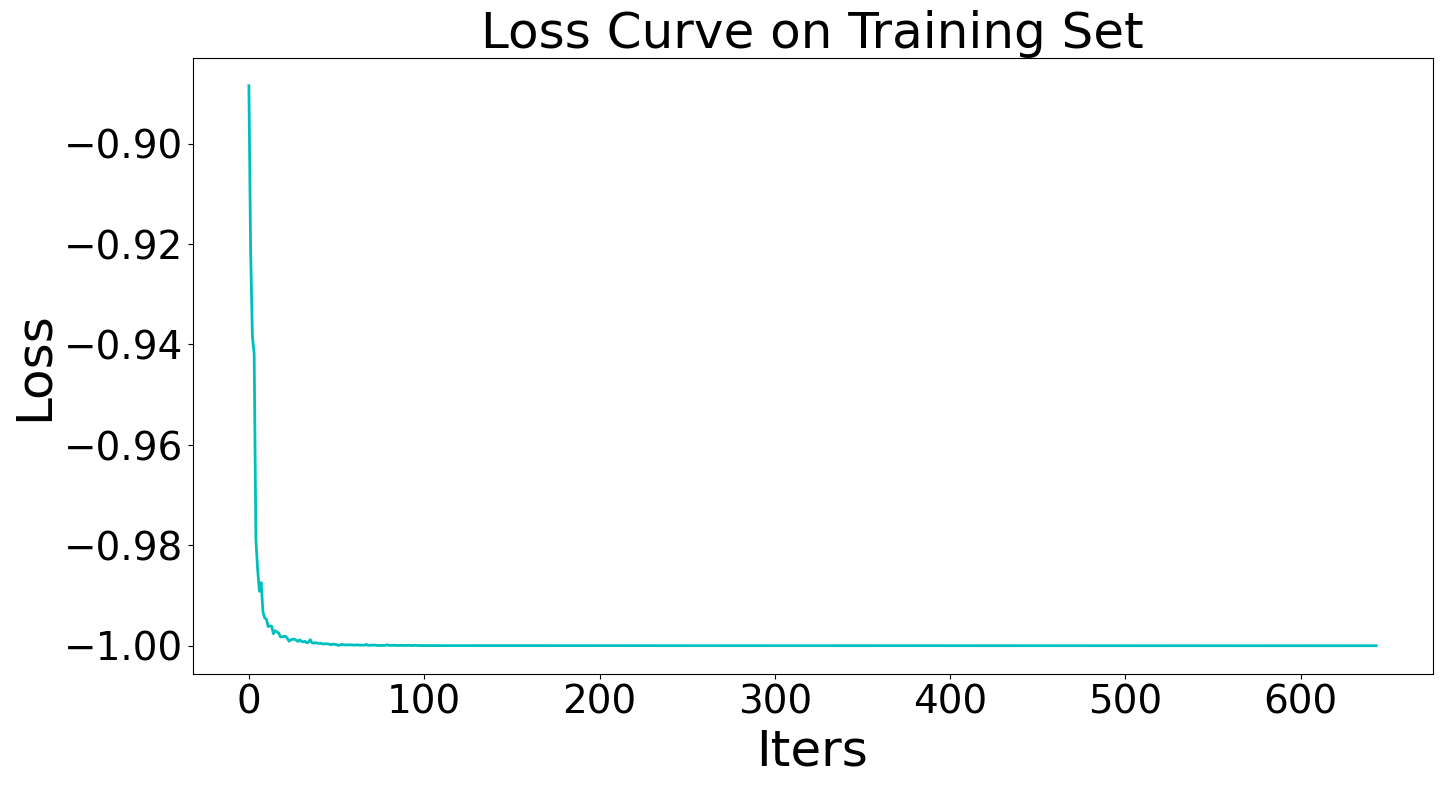

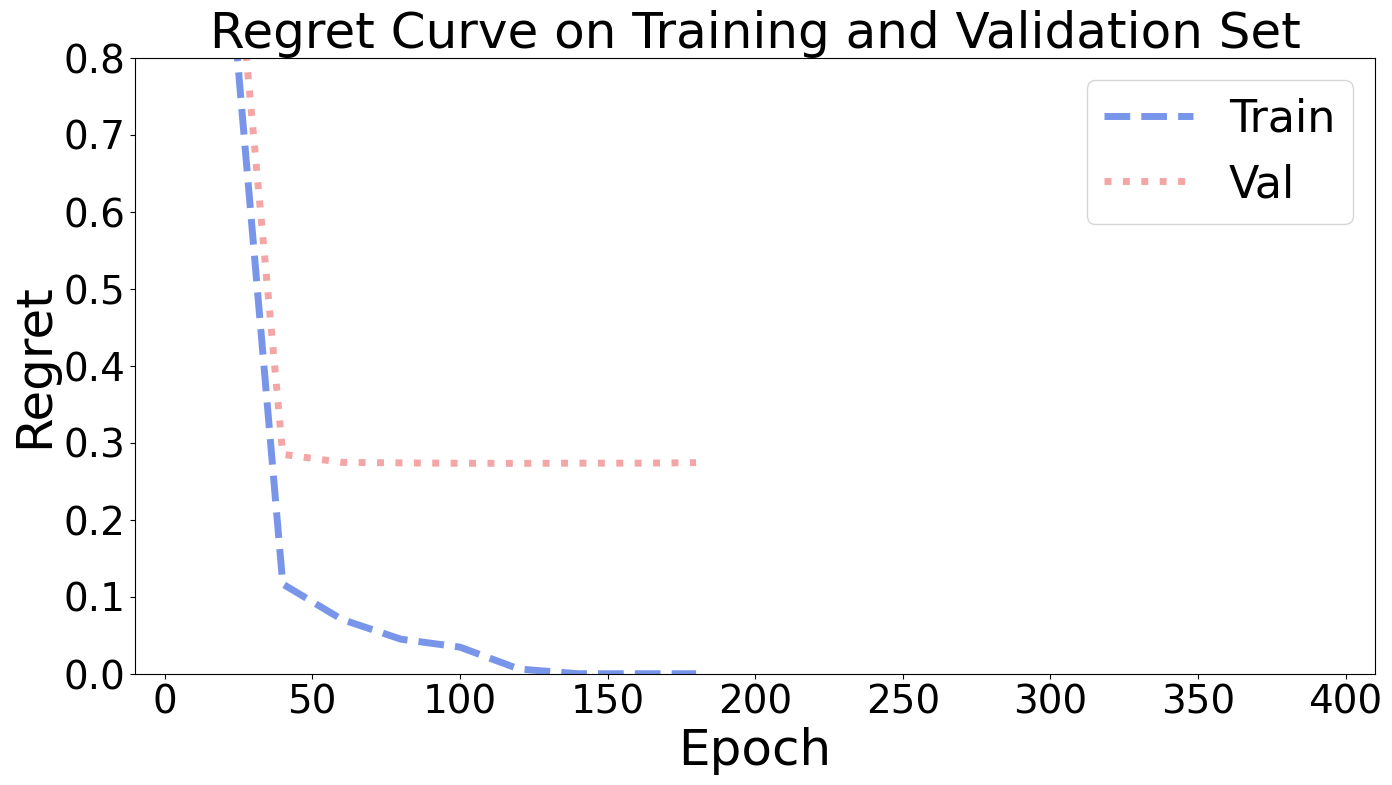

In [18]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### NNLS Method 

In [19]:
# init model
reg = LinearRegression()

In [20]:
from func import nnlsConeAlignedCosine
# init loss
ca_cos = nnlsConeAlignedCosine(optmodel)

In [21]:
lr = 5e-2
num_epochs = 400
log_step = 20
loss_log, regret_log_trn, regret_log_val = train(reg, ca_cos, lr, num_epochs, log_step)

Epoch   0, Loss:  -0.9569, Train Regret:  95.7856%, Val Regret: 113.5286%
Epoch  20, Loss:  -1.0000, Train Regret:  11.0466%, Val Regret:  28.9963%
Epoch  40, Loss:  -1.0000, Train Regret:   7.9454%, Val Regret:  27.9698%
Epoch  60, Loss:  -1.0000, Train Regret:   5.6429%, Val Regret:  27.7208%
Epoch  80, Loss:  -1.0000, Train Regret:   2.7328%, Val Regret:  27.9445%
Epoch 100, Loss:  -1.0000, Train Regret:   0.5609%, Val Regret:  27.9091%
Epoch 120, Loss:  -1.0000, Train Regret:   0.0000%, Val Regret:  27.9062%
Early Stop!
Elapsed Time: 135.54 Sec


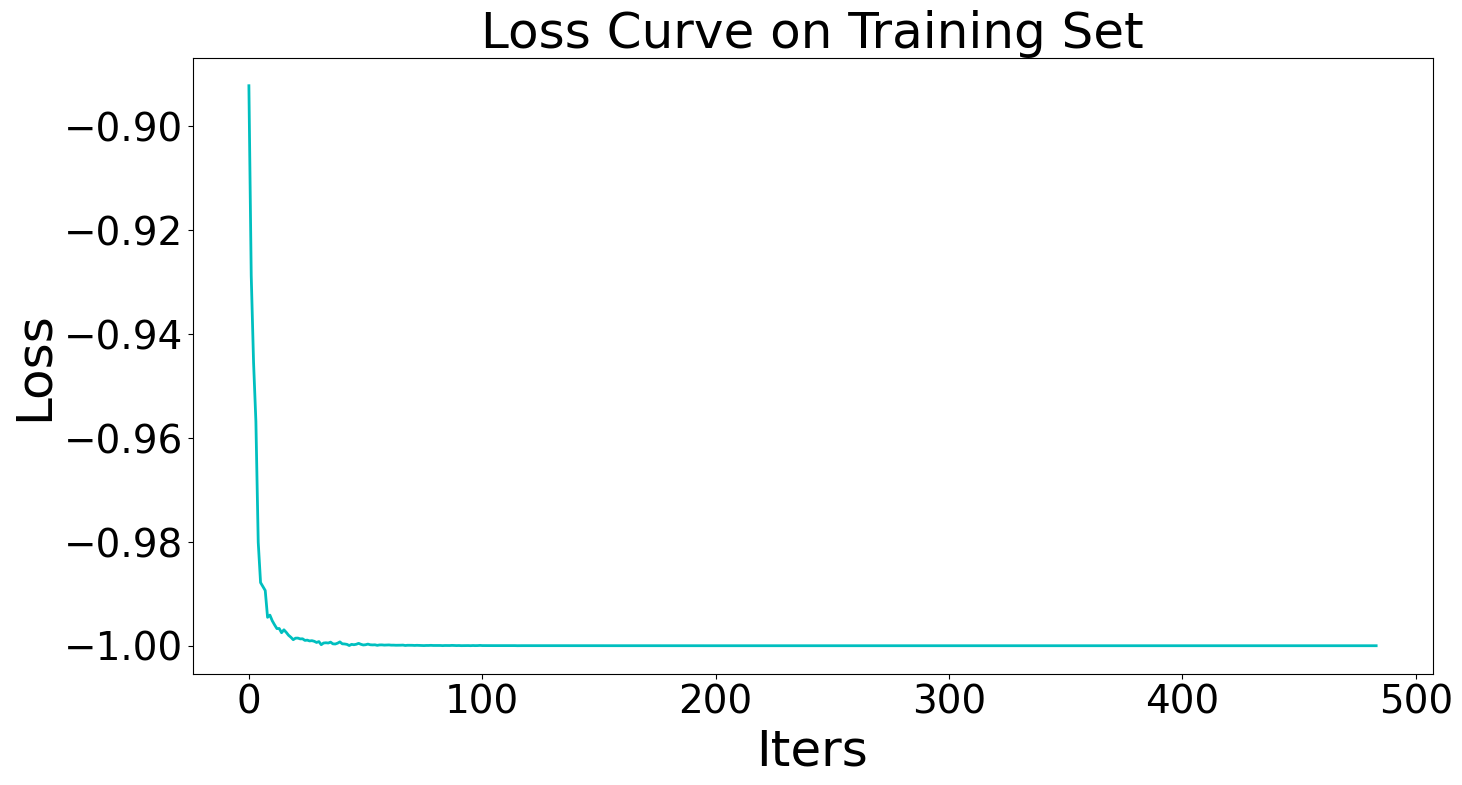

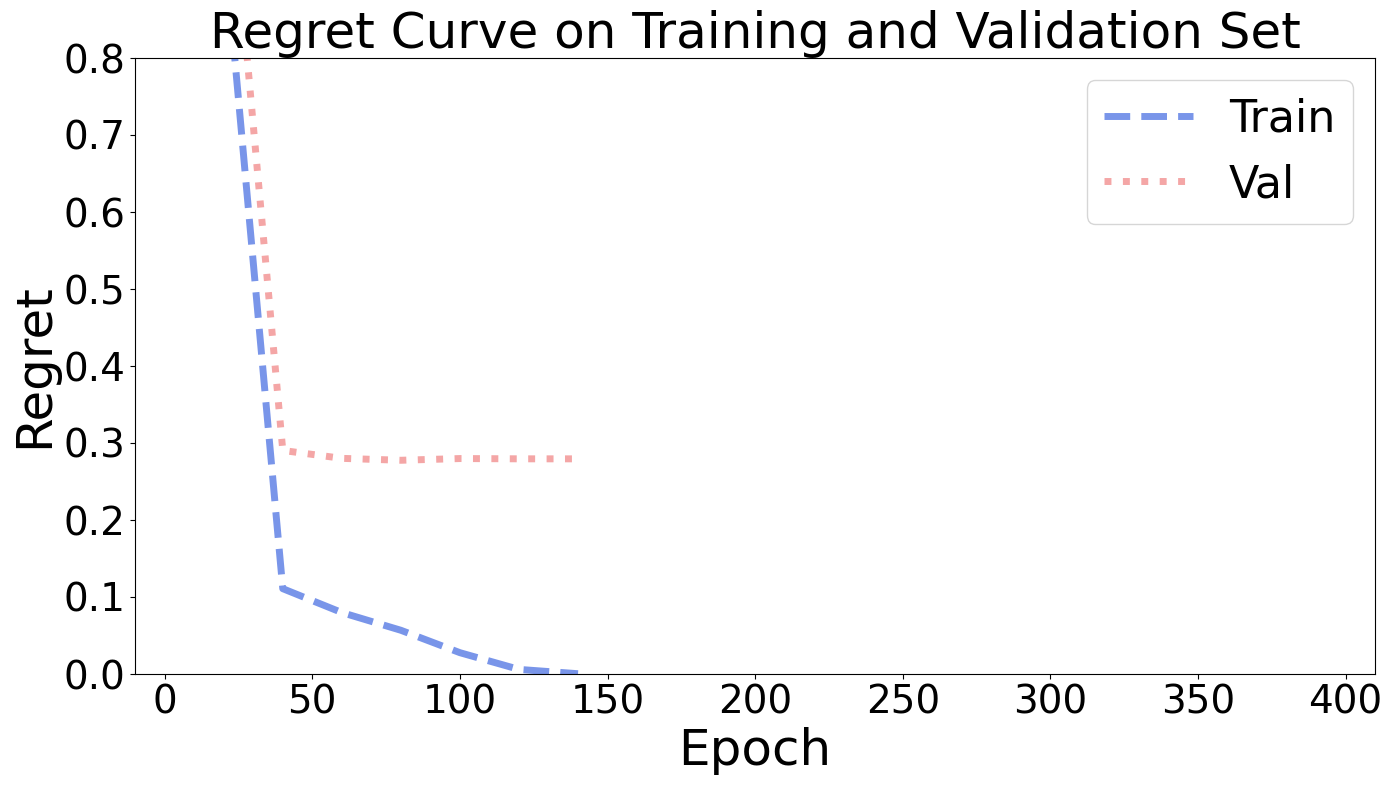

In [22]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Sampling Method

In [23]:
# init model
reg = LinearRegression()

In [24]:
from func import samplingConeAlignedCosine
# init loss
ca_cos = samplingConeAlignedCosine(optmodel, n_samples=100)

In [25]:
lr = 5e-2
num_epochs = 400
log_step = 20
loss_log, regret_log_trn, regret_log_val = train(reg, ca_cos, lr, num_epochs, log_step)

Epoch   0, Loss:  -0.3007, Train Regret: 132.2328%, Val Regret: 143.8565%
Epoch  20, Loss:  -0.7987, Train Regret:  14.8168%, Val Regret:  24.4281%
Epoch  40, Loss:  -0.8040, Train Regret:  13.9149%, Val Regret:  23.3209%
Epoch  60, Loss:  -0.7881, Train Regret:  15.1357%, Val Regret:  23.2195%
Epoch  80, Loss:  -0.7966, Train Regret:  15.1260%, Val Regret:  23.3579%
Epoch 100, Loss:  -0.8067, Train Regret:  14.0484%, Val Regret:  22.4609%
Epoch 120, Loss:  -0.7754, Train Regret:  13.6612%, Val Regret:  22.4479%
Epoch 140, Loss:  -0.7758, Train Regret:  14.2349%, Val Regret:  21.4759%
Epoch 160, Loss:  -0.8287, Train Regret:  13.7314%, Val Regret:  22.9334%
Epoch 180, Loss:  -0.7476, Train Regret:  15.0648%, Val Regret:  22.3153%
Epoch 200, Loss:  -0.8486, Train Regret:  15.1771%, Val Regret:  22.2089%
Early Stop!
Elapsed Time: 16.47 Sec


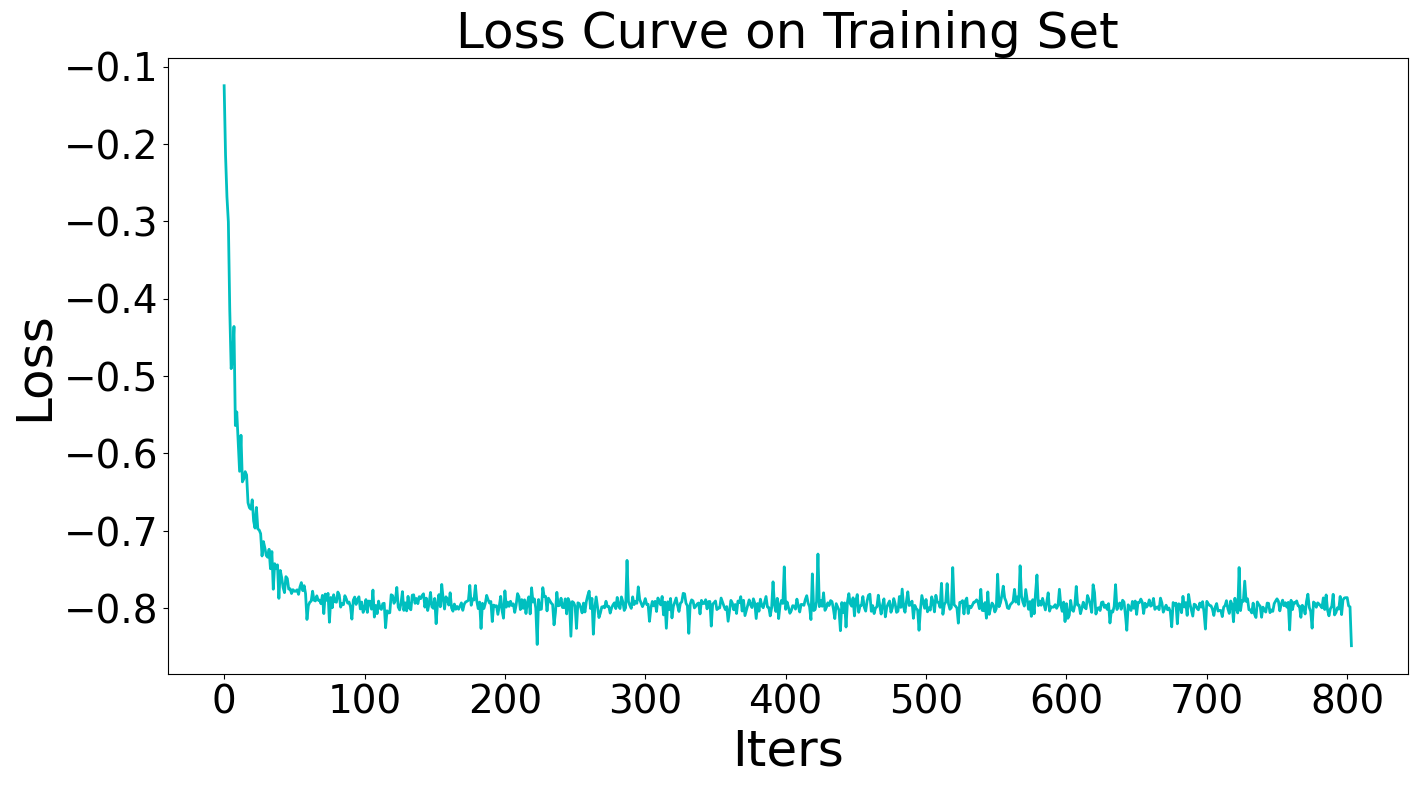

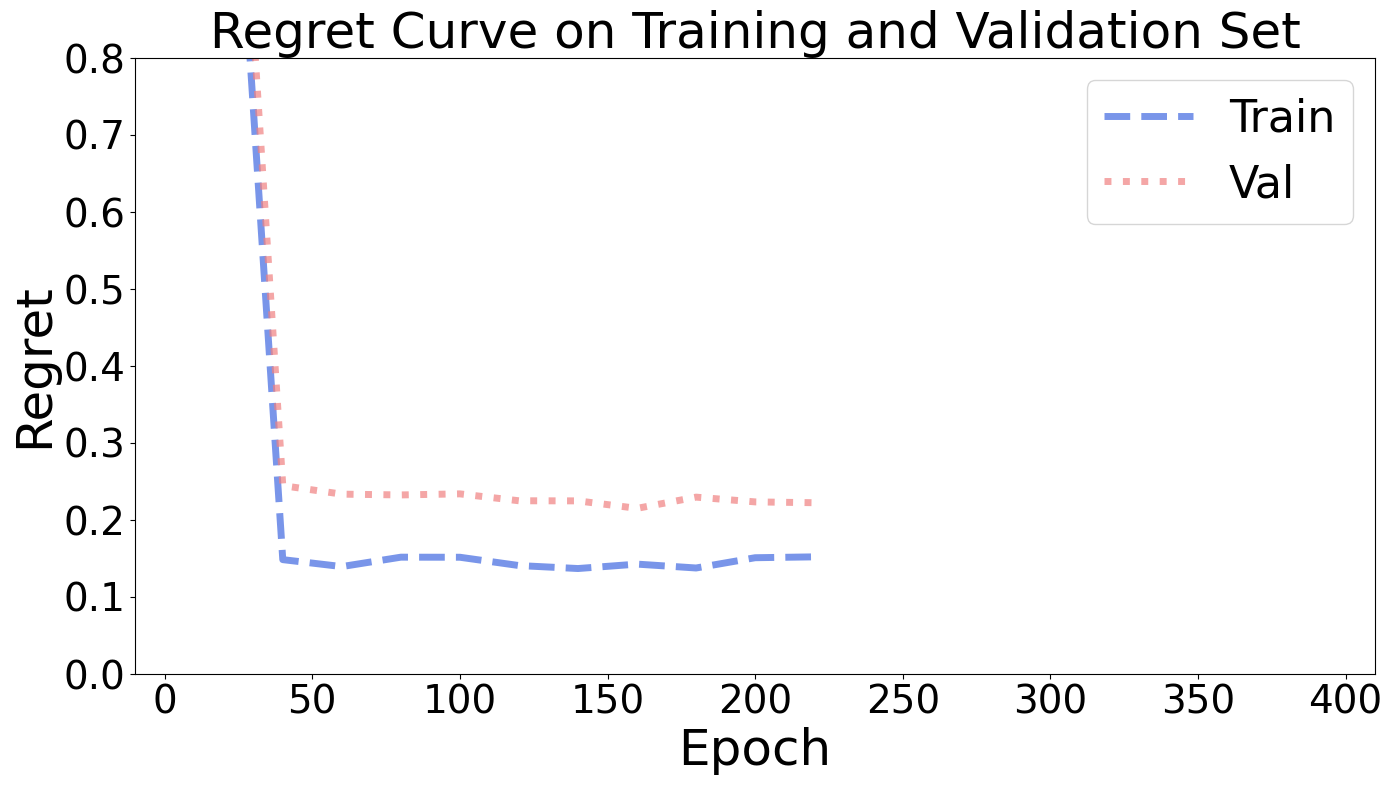

In [26]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Sign Method 

In [27]:
# init model
reg = LinearRegression()

In [28]:
from func import signConeAlignedCosine
# init loss
ca_cos = signConeAlignedCosine(optmodel)

In [29]:
lr = 5e-2
num_epochs = 400
log_step = 20
loss_log, regret_log_trn, regret_log_val = train(reg, ca_cos, lr, num_epochs, log_step)

Epoch   0, Loss:  -0.8814, Train Regret: 118.6455%, Val Regret: 130.7181%
Epoch  20, Loss:  -0.9982, Train Regret:  17.7283%, Val Regret:  32.9497%
Epoch  40, Loss:  -0.9991, Train Regret:  16.0107%, Val Regret:  33.7158%
Epoch  60, Loss:  -0.9993, Train Regret:  15.7229%, Val Regret:  35.9918%
Epoch  80, Loss:  -0.9997, Train Regret:  16.6055%, Val Regret:  38.4080%
Early Stop!
Elapsed Time: 3.18 Sec


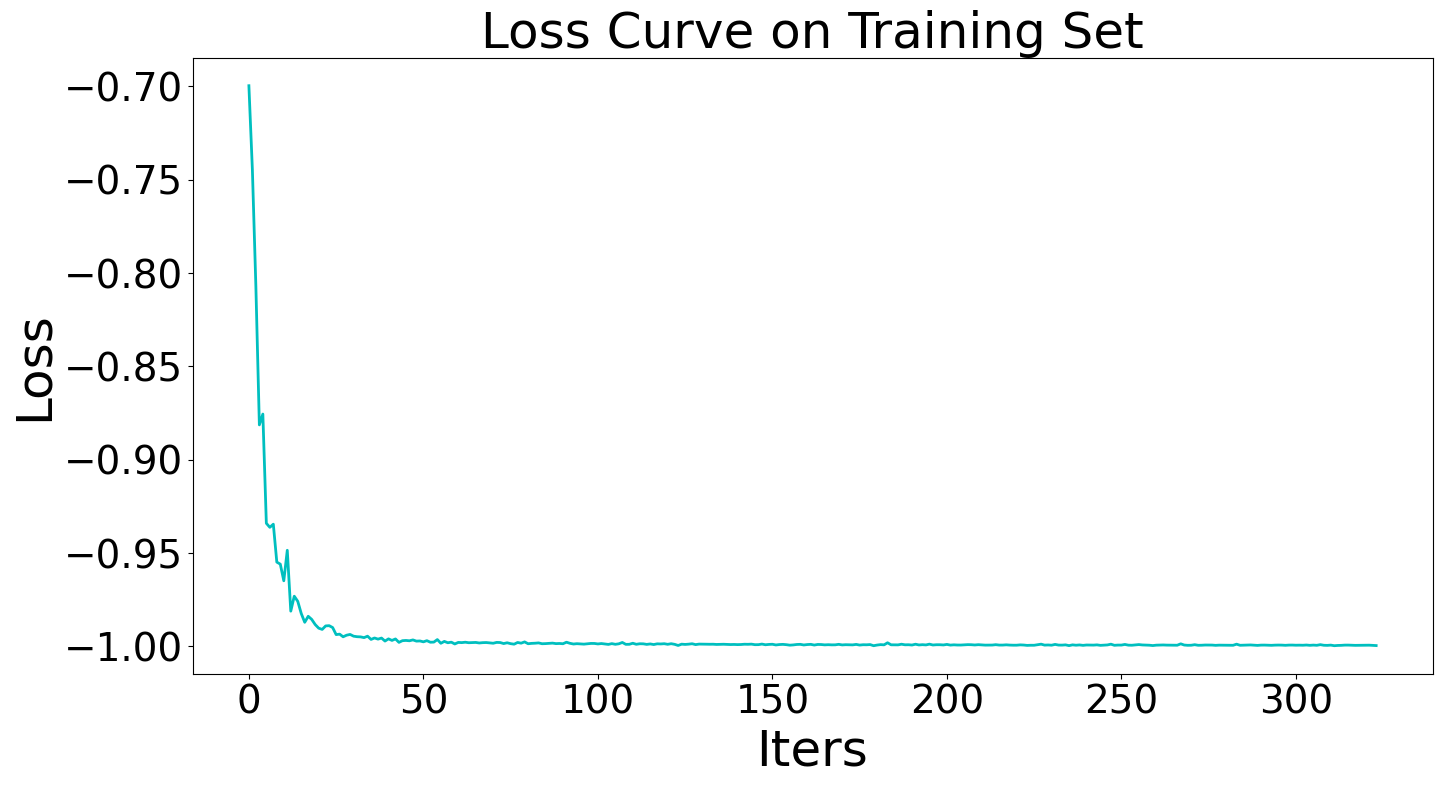

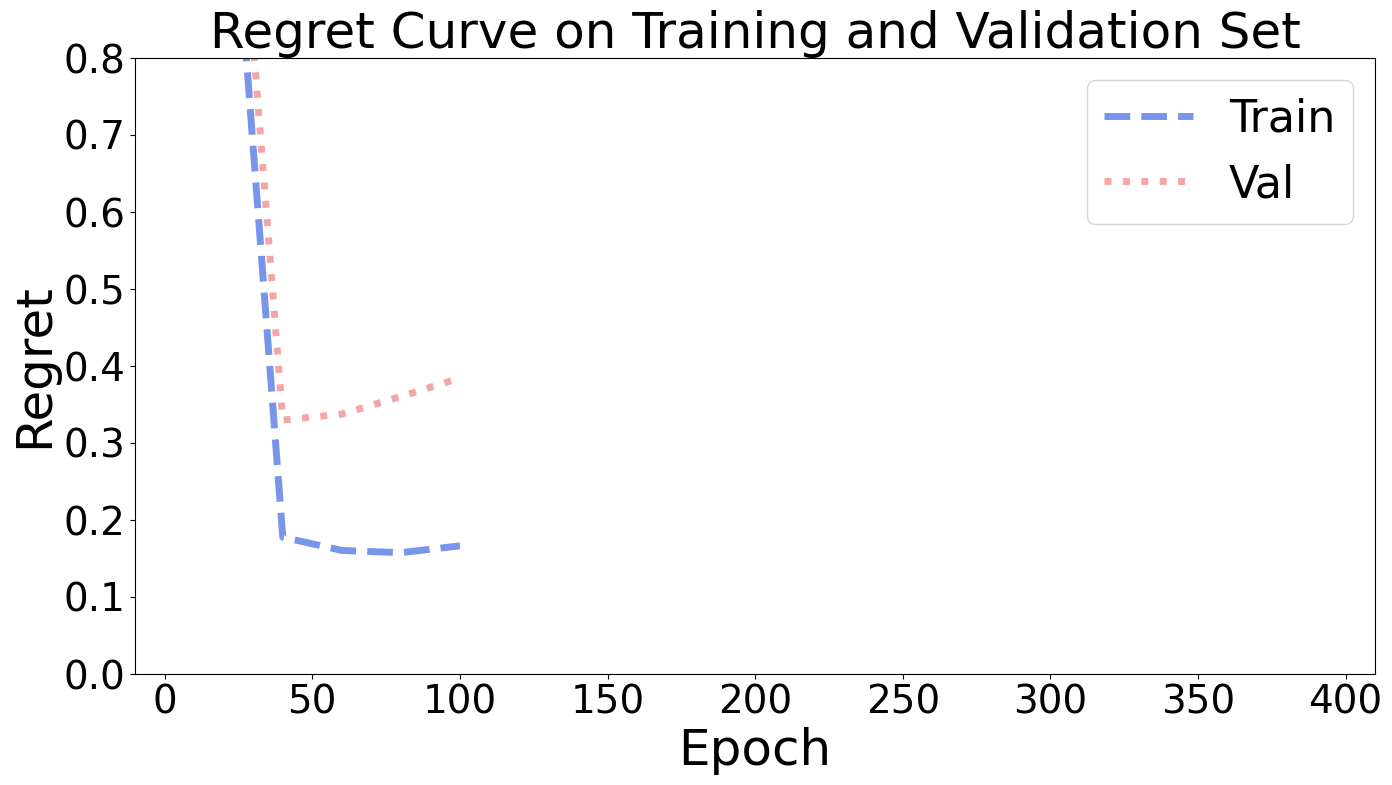

In [30]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### PFYL 

In [31]:
# init model
reg = LinearRegression()

In [32]:
from pyepo.func import perturbedFenchelYoung
# init pfyl loss
pfy = perturbedFenchelYoung(optmodel, n_samples=3, sigma=1.0)

Num of cores: 1


In [33]:
lr = 1e-2
num_epochs = 400
log_step = 20
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
# set stopper
stopper = earlyStopper(patience=3)
# init log
loss_log = []
regret_log_trn = [pyepo.metric.regret(reg, optmodel, loader_train_cost)]
regret_log_val = [pyepo.metric.regret(reg, optmodel, loader_test)]
# running time
elapsed = 0
for epoch in range(num_epochs):
    tick = time.time()
    for data in loader_train:
        x, _, w, _ = data
        # forward pass
        cp = reg(x)
        loss = pfy(cp, w)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_log.append(loss.item())
    # record time
    tock = time.time()
    elapsed += tock - tick
    if (epoch+1) % log_step == 1:
        # regret
        regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
        regret_log_trn.append(regret_trn)
        regret_val = pyepo.metric.regret(reg, optmodel, loader_test)
        regret_log_val.append(regret_val)
        print("Epoch {:3}, Loss: {:8.4f}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
               format(epoch, loss.item(), regret_trn*100, regret_val*100))
        # early stop
        if stopper.stop(regret_val):
            print("Early Stop!")
            break
print("Elapsed Time: {:.2f} Sec".format(elapsed))

Epoch   0, Loss:  25.7778, Train Regret: 168.9461%, Val Regret: 177.2262%
Epoch  20, Loss:  16.1667, Train Regret:  11.3878%, Val Regret:  24.0178%
Epoch  40, Loss:  10.5556, Train Regret:   6.4422%, Val Regret:  18.3268%
Epoch  60, Loss:   9.7222, Train Regret:   4.5438%, Val Regret:  16.9213%
Epoch  80, Loss:   5.8333, Train Regret:   3.4211%, Val Regret:  15.9148%
Epoch 100, Loss:   8.6667, Train Regret:   3.4920%, Val Regret:  16.0923%
Epoch 120, Loss:   6.5556, Train Regret:   3.2624%, Val Regret:  15.9590%
Epoch 140, Loss:   6.8889, Train Regret:   2.8151%, Val Regret:  15.8124%
Epoch 160, Loss:   6.0556, Train Regret:   2.6365%, Val Regret:  15.9701%
Epoch 180, Loss:   6.3333, Train Regret:   1.9810%, Val Regret:  15.7691%
Epoch 200, Loss:   3.9444, Train Regret:   1.5727%, Val Regret:  15.8431%
Epoch 220, Loss:   3.0556, Train Regret:   1.1912%, Val Regret:  15.5773%
Epoch 240, Loss:   5.0000, Train Regret:   1.0311%, Val Regret:  16.0733%
Epoch 260, Loss:   3.3889, Train Regre

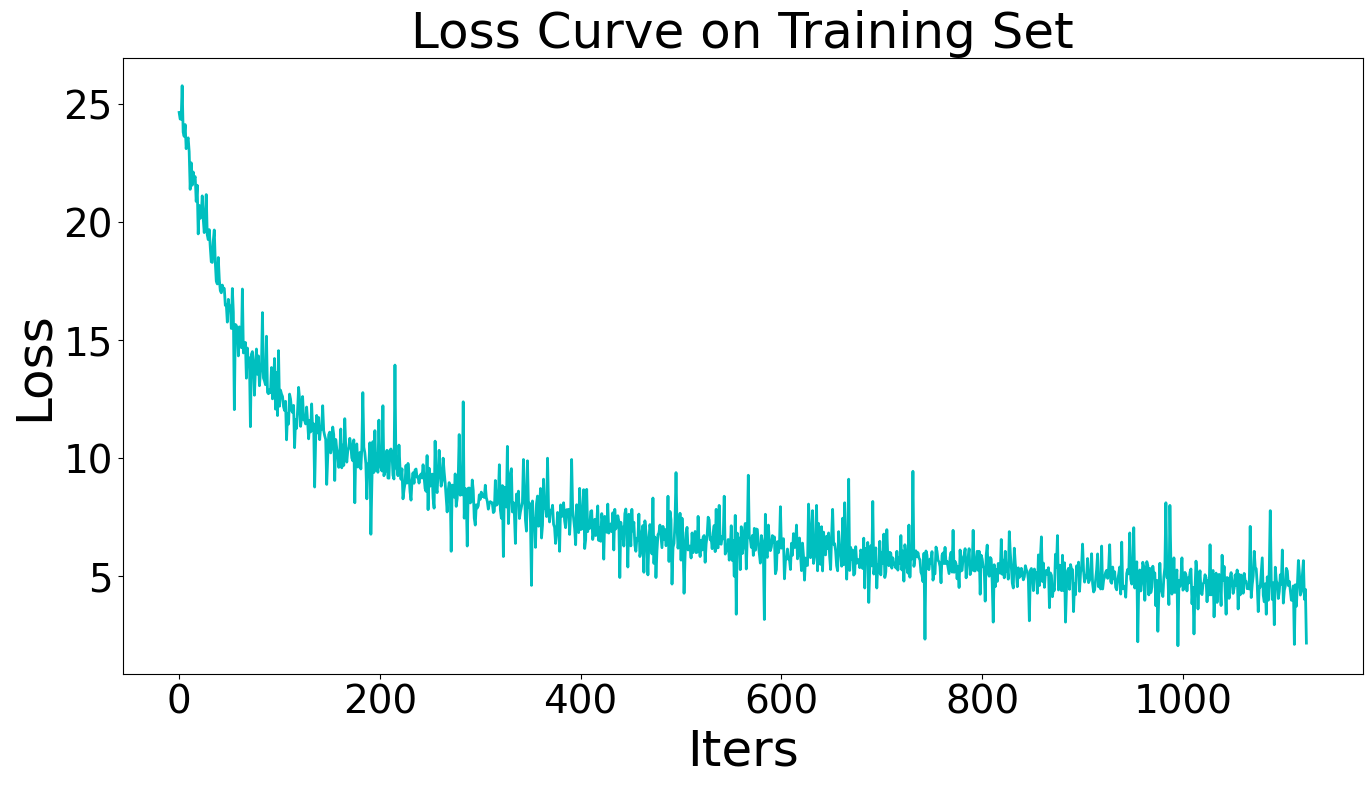

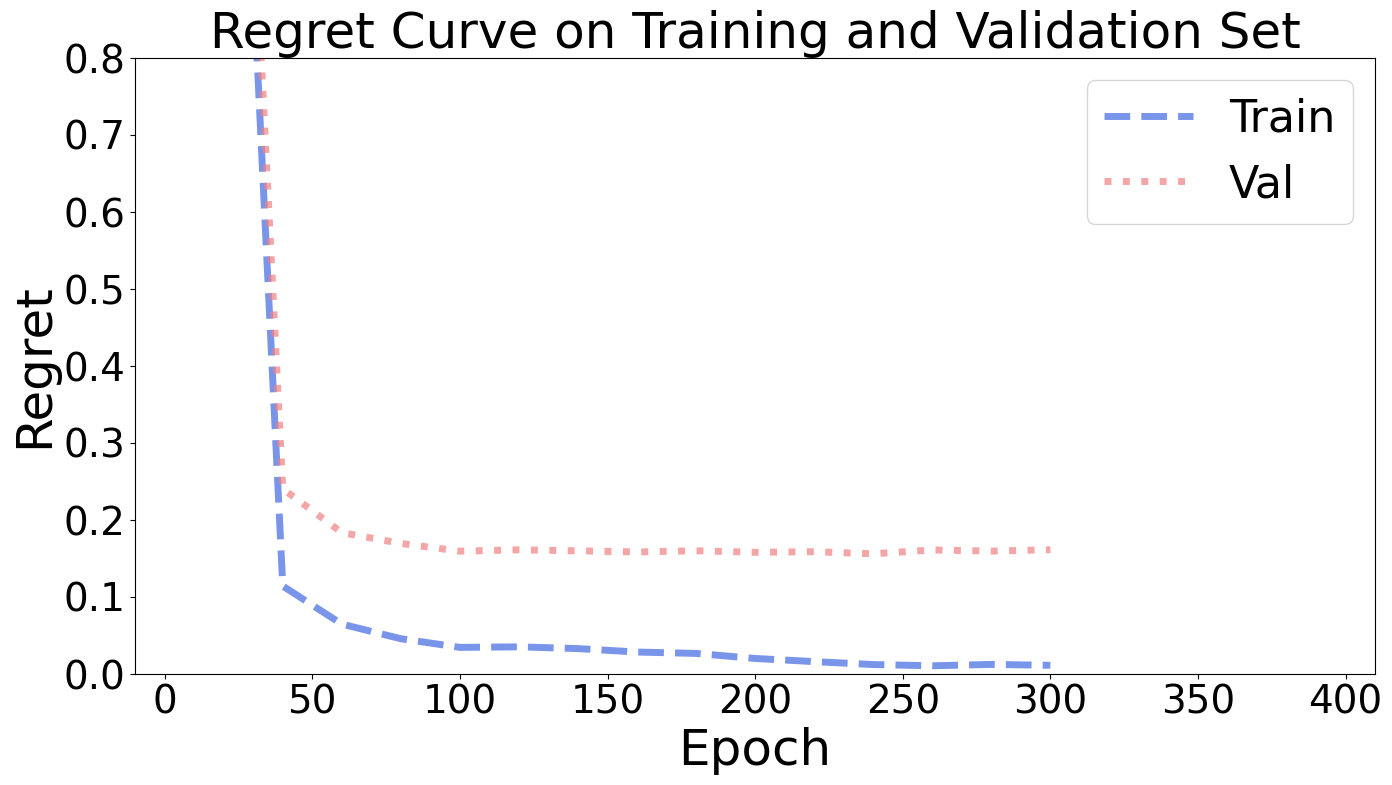

In [34]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)